In [1]:
import pandas_datareader.data as web
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import gzip, cPickle
from tqdm import tqdm 

from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa as tsa 
from statsmodels.tsa.stattools import coint

from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoLars
from statsmodels.tsa.stattools import adfuller as ADF
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from itertools import combinations
from tqdm import tqdm
import pickle
from datetime import datetime as dt
import math

C:\Users\Juntao\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## This step is to download and load all the ETF data

In [2]:
All_ETFs = pickle.load(open("MPP_ETFs_Production.p", "r"))

In [3]:
with gzip.open('ETFs_GSPC_MRP_Production.pkl.gz','r') as f:
    ETFs_GSPC = cPickle.load(f)

In [4]:
All_ETFs = ETFs_GSPC.iloc[:, :-1]

In [5]:
All_ETFs.head(2)

,XLK,VGT,IYW,RYT,IGM,XNTK,PNQI,XLF,VFH,KBE,...,XLU,VPU,IDU,RYU,PUI,VNQ,IYR,RWR,REM,USRT
Date,,,,,,,,,,,,,,,,,,,,,
2008-01-02,22.09874,53.268589,56.017902,45.235744,54.408684,27.862883,NaN,14.305944,41.652599,35.166389,...,28.566296,59.947933,71.388649,41.737343,14.337612,40.162682,42.196808,47.435150,8.983622,34.976913
2008-01-03,22.13258,52.997772,55.789246,44.755886,54.259819,27.940943,NaN,14.215148,41.288517,35.025986,...,28.525572,60.058559,71.592514,41.917027,14.271438,38.910671,40.830173,46.044064,8.910232,33.672215


In [6]:
All_ETFs_log = All_ETFs.apply(np.log)

All_ETFs_log .drop(['RYF','FTXO','PNQI', 'JHMC','PSCH','PSCI','PSCC',
                           'XNTK','PSCM','XTL','REM','RYF','XME'], axis=1, inplace=True) # 51Z ETFs left

In [7]:
All_ETFs_log.columns

Index([u'XLK', u'VGT', u'IYW', u'RYT', u'IGM', u'XLF', u'VFH', u'KBE', u'IYF',
       u'XLY', u'VCR', u'IYC', u'XRT', u'RCD', u'RXI', u'XLV', u'IBB', u'VHT',
       u'IYH', u'RYH', u'XLI', u'VIS', u'IYJ', u'RGI', u'XLE', u'VDE', u'IYE',
       u'RYE', u'FXN', u'XLP', u'VDC', u'IYK', u'RHS', u'FXG', u'XLB', u'VAW',
       u'IYM', u'RTM', u'VOX', u'IXP', u'IYZ', u'XLU', u'VPU', u'IDU', u'RYU',
       u'PUI', u'VNQ', u'IYR', u'RWR', u'USRT'],
      dtype='object')

In [8]:
len(All_ETFs_log.columns)

50

In [9]:
All_ETFs_log.shape

(2539, 50)

# SPTR

In [10]:
# pickle.dump(ETFs_GSPC, open("ETFs_GSPC_MRP_Production.p", "w"))
with gzip.open('sptr.pkl.gz','r') as f:
    SPTR = cPickle.load(f)

SPTR_log = np.log(SPTR[['Adj Close']].copy())
SPTR_log.head()

SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()
SPTR_log_test = SPTR_log.loc["2014-01-01": "2017-12-31"].copy()

SPTR_log_test['Daily_Return'] = SPTR_log_test['Adj Close'].diff()
SPTR_log_test['Daily_Return'][0] = 0
SPTR_log_test['Cumsum Daily_Return'] = SPTR_log_test['Daily_Return'].cumsum()

## Lasso Alpha finding 

In [77]:
%%time
j = 0
m = 0

stationary_alpha = []

SPTR_log_train = SPTR_log.loc["2008-01": "2014-12-31"].copy()
All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2014-12-31"].copy()

for i in tqdm(np.arange(0.000541, 0.021, 0.00001)):
    m+=1
    LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None,positive=True,random_state=123)
    LR_lasso.fit(All_ETFs_log_train,SPTR_log_train)
    LR_lasso_residual = SPTR_log_train.values.flatten() - LR_lasso.predict(All_ETFs_log_train)
    if check_for_stationarity_no_print(LR_lasso_residual.flatten(),cutoff=0.05):
        j+= 1
        stationary_alpha.append(LR_lasso.alpha)
        positive_number = sum(LR_lasso.coef_>0)
        negative_number = sum(LR_lasso.coef_<0)    
        print 'we get the right alpha'
        print '\nthe alpha in LASSO is %s and the P-value for ADF is %s'%(i, ADF(LR_lasso_residual.flatten())[1])
        print 'with in all coefficients, there are %s ETFs are positive'%(positive_number)
        print 'with in all coefficients, there are %s ETFs are negative'%(negative_number)
    

        
print '\n\ntotal %s LR models are stationary'%(j)
print 'total we tested %s models'%(m)

  0%|                                                                                         | 0/2046 [00:00<?, ?it/s]

we get the right alpha

the alpha in LASSO is 0.000541 and the P-value for ADF is 6.24298809031e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|                                                                                 | 1/2046 [00:00<03:34,  9.52it/s]

we get the right alpha

the alpha in LASSO is 0.000551 and the P-value for ADF is 6.23181655407e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|                                                                                 | 2/2046 [00:00<03:35,  9.48it/s]

we get the right alpha

the alpha in LASSO is 0.000561 and the P-value for ADF is 6.2205042073e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|                                                                                 | 3/2046 [00:00<03:35,  9.49it/s]

we get the right alpha

the alpha in LASSO is 0.000571 and the P-value for ADF is 6.20915644161e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|▏                                                                                | 4/2046 [00:00<03:35,  9.46it/s]

we get the right alpha

the alpha in LASSO is 0.000581 and the P-value for ADF is 6.19784777424e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000591 and the P-value for ADF is 6.18663473827e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|▏                                                                                | 6/2046 [00:00<03:33,  9.54it/s]

we get the right alpha

the alpha in LASSO is 0.000601 and the P-value for ADF is 6.17554082513e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000611 and the P-value for ADF is 6.16458771641e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|▎                                                                                | 8/2046 [00:00<03:29,  9.74it/s]

we get the right alpha

the alpha in LASSO is 0.000621 and the P-value for ADF is 6.15377529529e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000631 and the P-value for ADF is 6.14310385921e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  0%|▍                                                                               | 10/2046 [00:01<03:29,  9.71it/s]

we get the right alpha

the alpha in LASSO is 0.000641 and the P-value for ADF is 6.13256185241e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000651 and the P-value for ADF is 6.12214444159e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▍                                                                               | 12/2046 [00:01<03:27,  9.79it/s]

we get the right alpha

the alpha in LASSO is 0.000661 and the P-value for ADF is 6.21737740688e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000671 and the P-value for ADF is 6.35893208217e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▌                                                                               | 14/2046 [00:01<03:26,  9.82it/s]

we get the right alpha

the alpha in LASSO is 0.000681 and the P-value for ADF is 6.50005389064e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000691 and the P-value for ADF is 6.64160897487e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▋                                                                               | 16/2046 [00:01<03:24,  9.94it/s]

we get the right alpha

the alpha in LASSO is 0.000701 and the P-value for ADF is 6.78368675271e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▋                                                                               | 17/2046 [00:01<03:24,  9.93it/s]

we get the right alpha

the alpha in LASSO is 0.000711 and the P-value for ADF is 6.92630542508e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▋                                                                               | 18/2046 [00:01<03:24,  9.91it/s]

we get the right alpha

the alpha in LASSO is 0.000721 and the P-value for ADF is 7.06948138535e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▋                                                                               | 19/2046 [00:01<03:25,  9.85it/s]

we get the right alpha

the alpha in LASSO is 0.000731 and the P-value for ADF is 7.21323682763e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000741 and the P-value for ADF is 7.35722001359e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▊                                                                               | 21/2046 [00:02<03:25,  9.87it/s]

we get the right alpha

the alpha in LASSO is 0.000751 and the P-value for ADF is 7.50132382598e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000761 and the P-value for ADF is 7.64532567485e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▉                                                                               | 23/2046 [00:02<03:24,  9.91it/s]

we get the right alpha

the alpha in LASSO is 0.000771 and the P-value for ADF is 7.78845233077e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000781 and the P-value for ADF is 7.92949804502e-06
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|▉                                                                               | 25/2046 [00:02<03:23,  9.94it/s]

we get the right alpha

the alpha in LASSO is 0.000791 and the P-value for ADF is 8.07943290914e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000801 and the P-value for ADF is 8.2300126354e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|█                                                                               | 27/2046 [00:02<03:22,  9.96it/s]

we get the right alpha

the alpha in LASSO is 0.000811 and the P-value for ADF is 8.38053852062e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000821 and the P-value for ADF is 8.53100307578e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  1%|█▏                                                                              | 29/2046 [00:02<03:21,  9.99it/s]

we get the right alpha

the alpha in LASSO is 0.000831 and the P-value for ADF is 8.68159697244e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000841 and the P-value for ADF is 8.8325706117e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▏                                                                              | 31/2046 [00:03<03:21, 10.02it/s]

we get the right alpha

the alpha in LASSO is 0.000851 and the P-value for ADF is 8.98354614451e-06
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha

the alpha in LASSO is 0.000861 and the P-value for ADF is 0.00561331177226
with in all coefficients, there are 12 ETFs are positive
with in all coefficients, there are 0 ETFs are negative


  2%|█▎                                                                              | 33/2046 [00:03<03:20, 10.04it/s]

we get the right alpha

the alpha in LASSO is 0.000871 and the P-value for ADF is 0.00575070632529
with in all coefficients, there are 11 ETFs are positive
with in all coefficients, there are 0 ETFs are negative
we get the right alpha


KeyboardInterrupt: 

In [11]:

LR_lasso = Lasso(alpha= 9.13e-05, fit_intercept=True,normalize=None, random_state=123)
LR_lasso.fit(All_ETFs_log_train,SPTR_log_train)
LR_lasso_residual = SPTR_log_train.values.flatten() - LR_lasso.predict(All_ETFs_log_train)


NameError: name 'All_ETFs_log_train' is not defined

In [78]:
SPTR_log_train = SPTR_log.loc["2008-01": "2014-12-31"].copy()
All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2014-12-31"].copy()

def alpha_finding(X=All_ETFs_log_train, Y=SPTR_log_train, pos_no = 10):
    for i in np.arange(0.000001, 0.000611, 0.00001):
        LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None, random_state=123)
        #LR_lasso = Lasso(alpha=i, fit_intercept=True,normalize=None, random_state=123)
        LR_lasso.fit(X,Y)
        LR_lasso_residual = Y.values.flatten() - LR_lasso.predict(X)
        if check_for_stationarity_no_print(LR_lasso_residual.flatten(),cutoff=0.05):
            positive_number = sum(LR_lasso.coef_>0)
            negative_number = sum(LR_lasso.coef_<0)
            if (positive_number == pos_no and negative_number == 0):
                print 'we get the right alpha'
                print 'the alpha in LASSO is %s and the P-value for ADF is %s'%(i, ADF(LR_lasso_residual.flatten())[1])
                print 'with in all coefficients, there are %s ETFs are positive'%(positive_number)
                print 'with in all coefficients, there are %s ETFs are negative'%(negative_number)
                break

    return round(i,8) 

In [13]:
# SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()
# All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

# alpha_finding(X=All_ETFs_log_train, Y= SPTR_log_train, pos_no=5 )

## SPTR no balance

In [103]:
def SPTR_no_balance(alpha_input = 0.000001):  
    SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_year = Lasso(alpha=alpha_input, fit_intercept=True,normalize=None,positive=True,random_state=123)

    LR_lasso_year.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
    print('\n\n ')
    print('for LASSO alpha',LR_lasso_year.alpha)
    print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
    #print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )
    print('we select ETFs tickers are', All_ETFs_log_train.columns[LR_lasso_year.coef_>0])

    index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_year.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test['portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).copy()

    portfolio_test['portfolio_test_intercept'] = portfolio_test['portf_forest']+LR_lasso_year.intercept_


    plt.figure(figsize=(25,8))
    plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='No balance Portfolio' )
    plt.legend(loc='upper left')
    plt.title('Comparison between real S&P500 and portfolio constructed on test data')
    plt.show()

    portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
    portfolio_test['Daily_Return'][0] = 0
    portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

    portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
    SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
    plt.legend(loc='upper left')
    plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
    plt.title('Cumsum Return SPTR and Portfolio')
    plt.show()
    
    plt.figure(figsize=(25,8))
    plt.title('Cumsum daily return') 
    plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='No balance Portfolio' )
    plt.legend(loc='upper left')
    plt.show()

    Track_error_annual = portfolio_test['Daily_Return'] - SPTR_log_test['Daily_Return']
    
    #print('Sum of Tracking error is %.8f') %(np.sum(np.absolute(Track_error_annual)))
    print('Mean of Tracking Error is %.8f') %(np.mean(Track_error_annual))
    
    print('Tracking Error Variance is %.8f') %(np.std(Track_error_annual))
    
   # print('Sum of square Tracking Error is %.8f') %(np.sum(Track_error_annual**2)) # this is the sum of square of tracking error

    print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_annual)/np.std(Track_error_annual))

    print('Annual Correlation coefficient between portfolio and SPTR is %.6f')%(
        np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test['Daily_Return'].values.flatten())[0,1])
    
    return portfolio_test



 
('for LASSO alpha', 0.000605)
('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('we select ETFs tickers are', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'IDU',
       u'RWR'],
      dtype='object'))


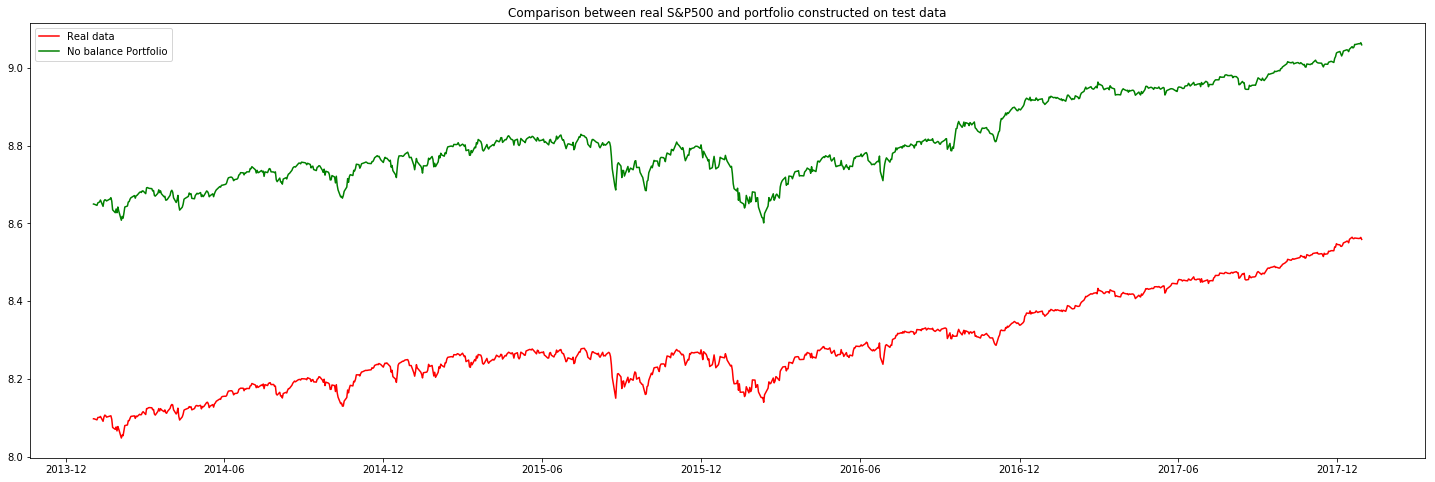

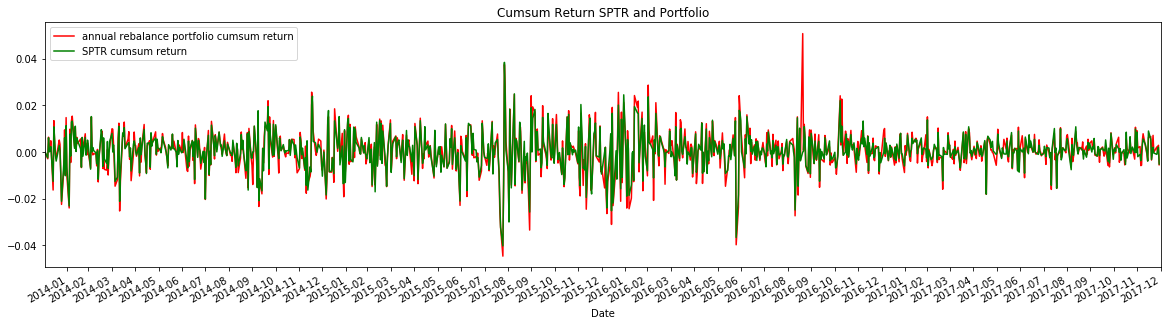

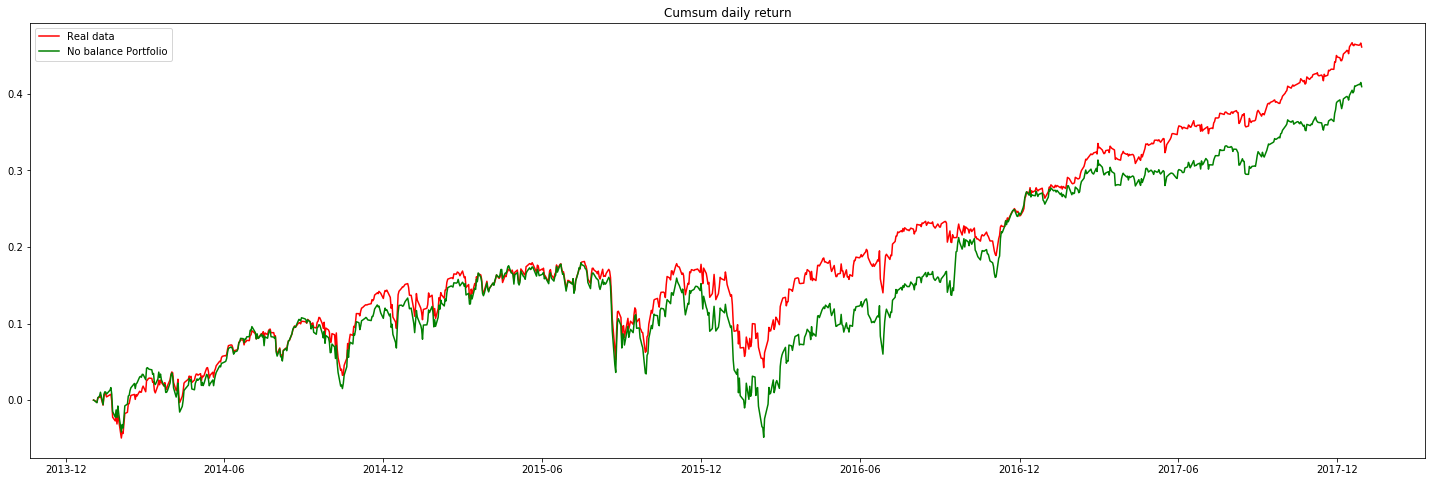

Mean of Tracking Error is -0.00004240
Tracking Error Variance is 0.00295876
Information ratio of the annual portfolio is -0.014
Annual Correlation coefficient between portfolio and SPTR is 0.943910


In [104]:
portfolio_test_nobalance =  SPTR_no_balance(alpha_input =0.000605)

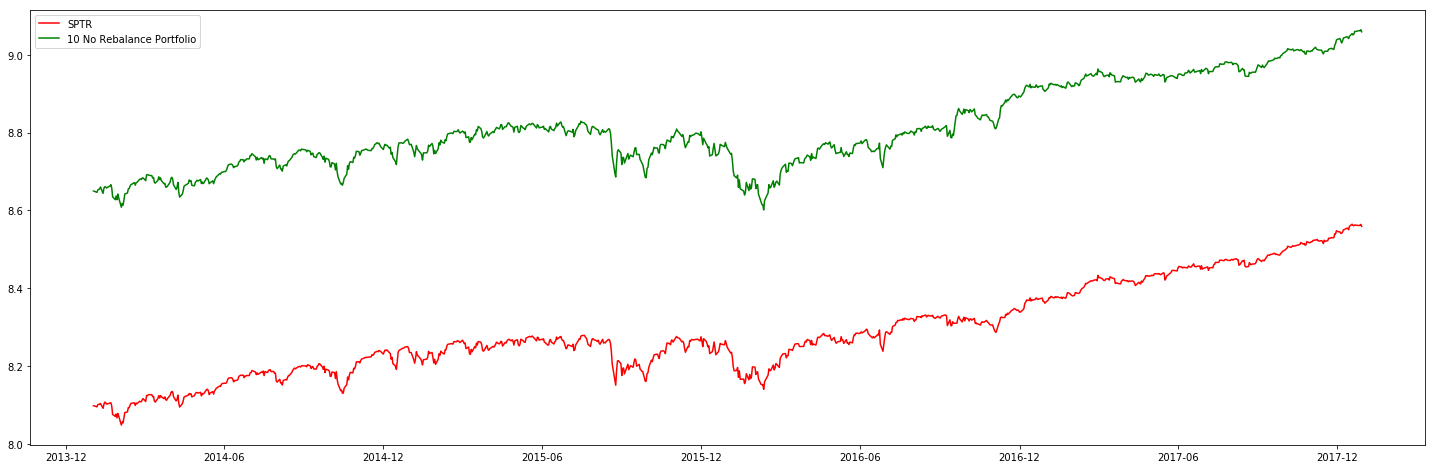

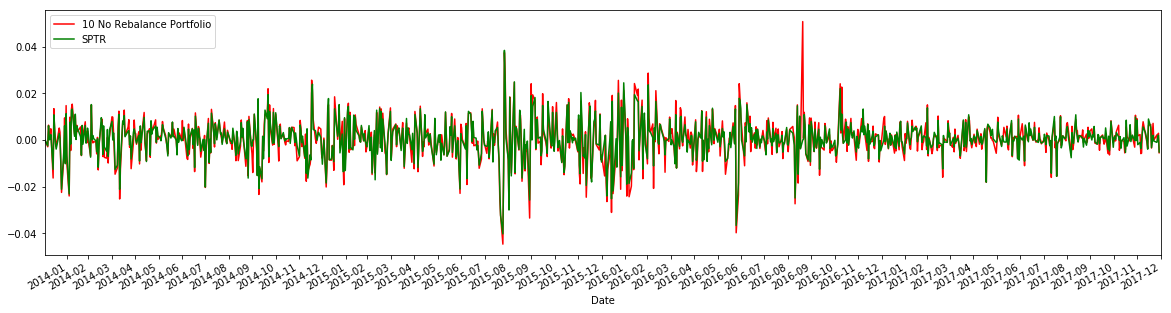

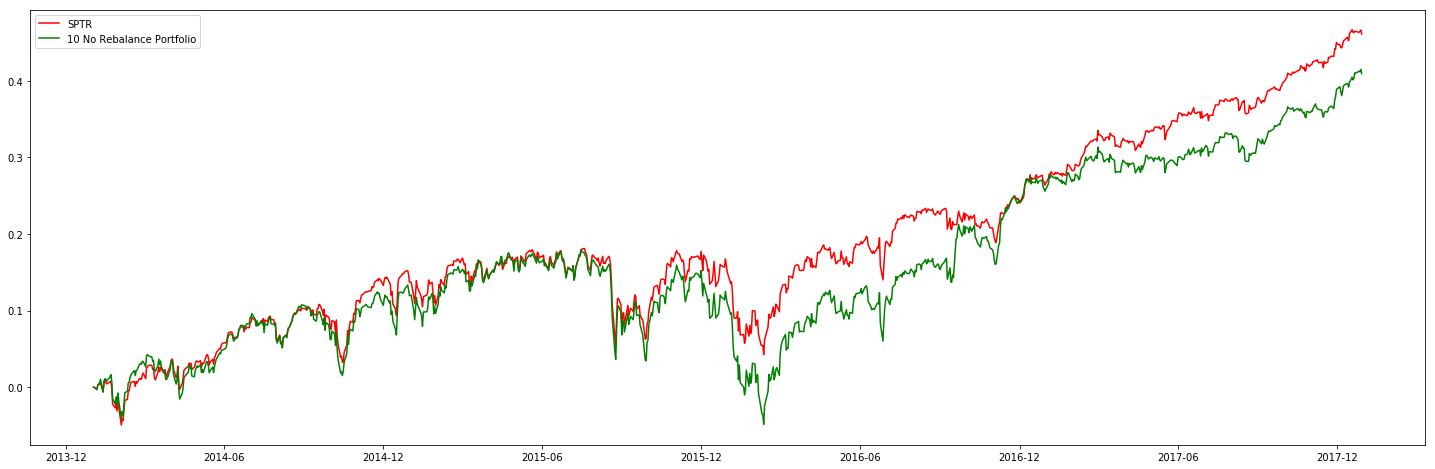

In [114]:
plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_nobalance['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 No Rebalance Portfolio' )
plt.legend(loc='upper left')
plt.show()
 

plt.figure(figsize=(25,8))
portfolio_test_nobalance['Daily_Return'].plot(kind='line',figsize=(20,5),label = '10 No Rebalance Portfolio',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.show()

plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_nobalance['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 No Rebalance Portfolio' )
plt.legend(loc='upper left')
#plt.title('Comparison of Cumsum Returns between SPTR and 15 ETFs portfolio semi-annual rebalance')
plt.show()


In [94]:
SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

LR_lasso_year = Lasso(alpha=0.000605, fit_intercept=True,normalize=None,positive=True,random_state=123)

LR_lasso_year.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])
print('\n\n ')
print('for LASSO alpha',LR_lasso_year.alpha)
print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
#print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )
print('we select ETFs tickers are', All_ETFs_log_train.columns[LR_lasso_year.coef_>0])

index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

coefficients= LR_lasso_year.coef_.copy()




 
('for LASSO alpha', 0.000605)
('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('we select ETFs tickers are', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'IDU',
       u'RWR'],
      dtype='object'))


In [95]:
coefficients

array([ 0.06106531,  0.        ,  0.        ,  0.        ,  0.        ,
        0.15907165,  0.        ,  0.        ,  0.        ,  0.16605534,
        0.07785133,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.11881862,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03534404,  0.        ,  0.        ,  0.13591954,
        0.        ,  0.        ,  0.02546049,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.02902329,  0.        ,
        0.        ,  0.        ,  0.        ,  0.04740607,  0.        ])

In [96]:
nonzero_coeff  = coefficients[~(coefficients==0)].copy()

In [97]:
nonzero_coeff

array([ 0.06106531,  0.15907165,  0.16605534,  0.07785133,  0.11881862,
        0.03534404,  0.13591954,  0.02546049,  0.02902329,  0.04740607])

In [98]:
for i in nonzero_coeff:
    print round(i,5)

0.06107
0.15907
0.16606
0.07785
0.11882
0.03534
0.13592
0.02546
0.02902
0.04741


In [99]:
nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

In [100]:
for i in nonzero_coeff:
    print round(i*100,2)

7.13
18.58
19.4
9.09
13.88
4.13
15.88
2.97
3.39
5.54


### SPTR year rebalance

In [296]:
All_ETFs_log.shape

(2539, 50)

In [74]:
pd.date_range(start='2014', end='2017', freq='A')

DatetimeIndex(['2014-12-31', '2015-12-31', '2016-12-31'], dtype='datetime64[ns]', freq='A-DEC')

In [80]:
def SPTR_annual_balance(alpha_input = 0.000001): 
    SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_year = Lasso(alpha=alpha_input, fit_intercept=True,normalize=None,positive=True,random_state=123)

    LR_lasso_year.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

    print('original coeff greater than 0 is ',np.sum(LR_lasso_year.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_year.coef_ < 0 ))
    #print('original coeff equal to 0 is ',np.sum(LR_lasso_year.coef_ == 0) )
    print('we select ETFs tickers are', All_ETFs_log_train.columns[LR_lasso_year.coef_>0])

    index_of_etfs = LR_lasso_year.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_year.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test.loc['2014','portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).loc['2014'].copy()

    portfolio_test.loc['2014','portfolio_test_intercept'] = portfolio_test.loc['2014','portf_forest']+LR_lasso_year.intercept_

    j = 1

    for i in pd.date_range(start='2014', end='2017', freq='A'):
        
        All_ETFs_log_train = All_ETFs_log.loc['2008': i].copy()

        SPTR_log_train = SPTR_log.loc['2008': i].copy()
        print('\n\nfor range in 2008 to'+str(i))
        new_alpha = alpha_finding(X=All_ETFs_log_train, Y= SPTR_log_train)
        
        Lasso_Model = Lasso(alpha= new_alpha,fit_intercept=True,normalize=None,random_state=123)

        Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

#         print('number of coeff greater than 0 is ',np.sum(Lasso_Model.coef_ > 0 ))

#         print('number of coeff leass than 0 is ' ,np.sum(Lasso_Model.coef_ < 0 ))

#         print('new alpha is ',new_alpha )
        
        print('we select ETFs tickers are', All_ETFs_log_train.columns[Lasso_Model.coef_>0])

        Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)

        check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
        
        index_of_etfs = Lasso_Model.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

        All_ETFs_log_year = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

        coefficients= Lasso_Model.coef_.copy()
        
        nonzero_coeff  = coefficients[~(coefficients==0)].copy()

        nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

        portfolio_test.loc[str(2014+j),'portf_forest'] = All_ETFs_log_year.dot(nonzero_coeff).loc[str(2014+j)].copy()

        portfolio_test.loc[str(2014+j),'portfolio_test_intercept'] = portfolio_test.loc[str(2014+j),'portf_forest']+Lasso_Model.intercept_


        j+=1

        print('%sth loop is good'%(j))

    SPTR_log_test = SPTR_log.loc["2014-01-01": "2017-12-31"].copy()
    plt.figure(figsize=(25,8))
    plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='annual Portfolio' )
    plt.legend(loc='upper left')
    plt.title('Comparison between real S&P500 and portfolio constructed on test data')
    plt.show()

    SPTR_log_test['Daily_Return'] = SPTR_log_test['Adj Close'].diff()
    SPTR_log_test['Daily_Return'][0] = 0
    SPTR_log_test['Cumsum Daily_Return'] = SPTR_log_test['Daily_Return'].cumsum()

    portfolio_test['Daily_Return'] = portfolio_test['portf_forest'].diff()
    portfolio_test['Daily_Return'][0] = 0
    # to adjust after rebalancing, the price change. we don't want to count the daily return after rebalancing
    for i in ['2015-01-02','2016-01-04','2017-01-03']:
        portfolio_test.loc[i,'Daily_Return'] = 0
        SPTR_log_test.loc[i,'Daily_Return'] = 0
    portfolio_test['Cumsum Daily_Return'] = portfolio_test['Daily_Return'].cumsum()

    portfolio_test['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'annual rebalance portfolio cumsum return',style='r-')
    SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
    plt.legend(loc='upper left')
    plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
    plt.title('Daily Return SPTR and Portfolio')
    plt.show()

    plt.figure(figsize=(25,8))
    plt.title('Cumsum daily return') 
    plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='Annual balance Portfolio' )
    plt.legend(loc='upper left')
    plt.show()



    Track_error_annual = portfolio_test['Daily_Return'] - SPTR_log_test['Daily_Return']

    # to adjust after rebalancing, the price change. 

    for i in ['2015-01-02','2016-01-04','2017-01-03']:
        Track_error_annual.loc[i] = 0

    print('Mean of Tracking Error is %.8f') %(np.mean(Track_error_annual))
    
    print('std of Tracking Error is %.8f') %(np.std(Track_error_annual))
    #print('Sum of  Tracking Error is %.8f') %(np.sum(np.abs(Track_error_annual)))

    print('Information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_annual)/np.std(Track_error_annual))

    print('Annual Correlation coefficient between portfolio and SPTR is %.6f')%(
        np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test['Daily_Return'].values.flatten())[0,1])
    
    return portfolio_test

('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('we select ETFs tickers are', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'IDU',
       u'RWR'],
      dtype='object'))


for range in 2008 to2014-12-31 00:00:00


C:\Users\Juntao\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


('we select ETFs tickers are', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'XLV', u'IBB', u'XLI', u'VIS', u'XLE',
       u'FXN', u'IDU', u'RWR'],
      dtype='object'))
p-value = 6.17663445897e-06 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-12-31 00:00:00
('we select ETFs tickers are', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'XLV', u'IBB', u'XLI', u'VIS', u'XLE',
       u'IDU', u'RWR'],
      dtype='object'))
p-value = 2.26881720923e-06 The series  is likely stationary.
3th loop is good


for range in 2008 to2016-12-31 00:00:00
('we select ETFs tickers are', Index([u'XLK', u'XLF', u'IYF', u'XLY', u'IYC', u'XLV', u'IBB', u'XLI', u'VIS',
       u'XLE', u'VAW', u'IDU', u'RWR'],
      dtype='object'))
p-value = 0.00370110046553 The series  is likely stationary.
4th loop is good


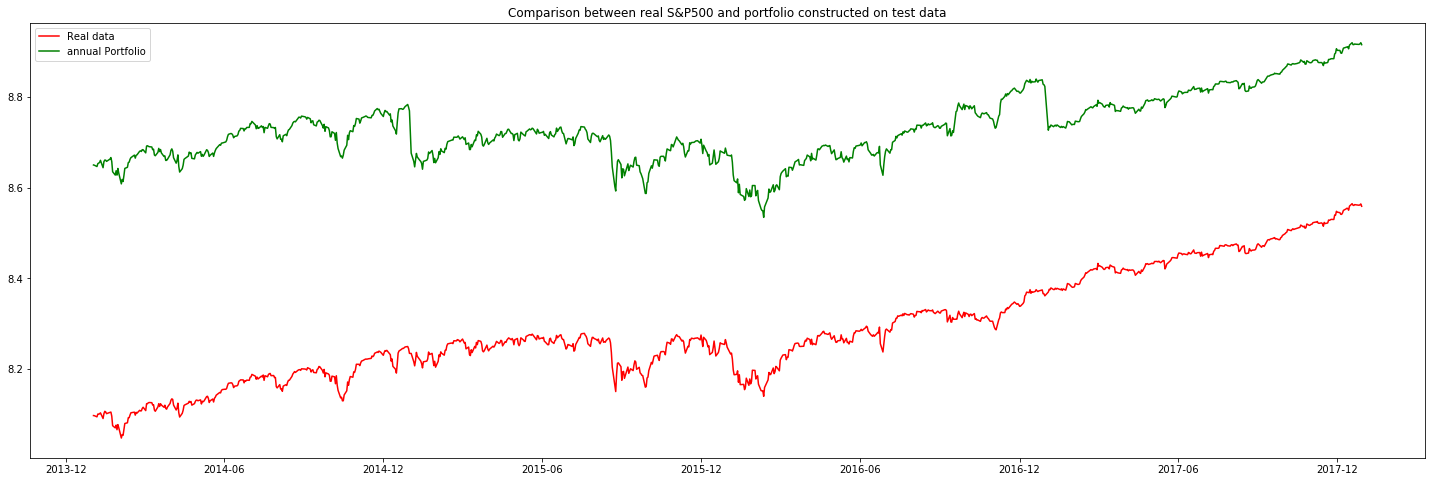

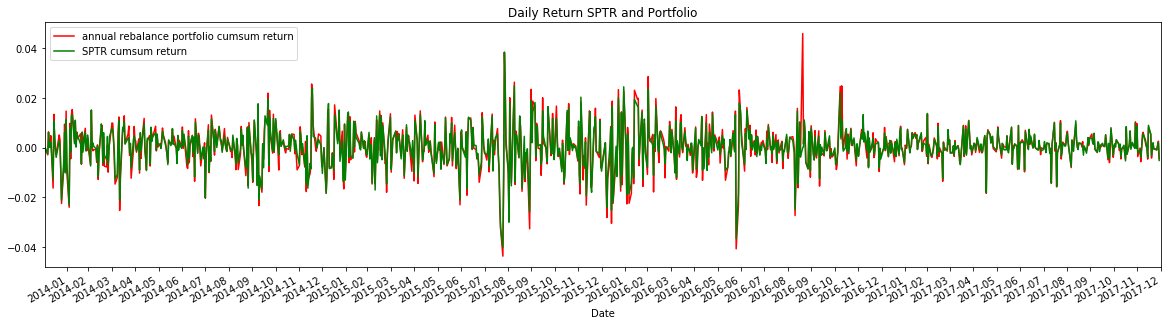

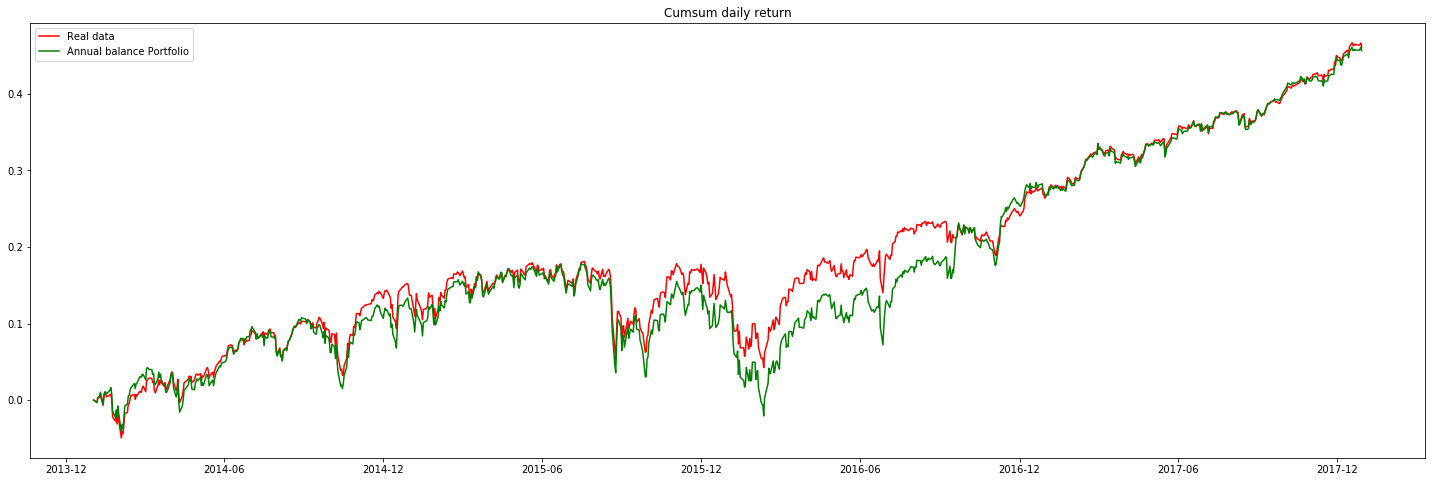

Mean of Tracking Error is -0.00001161
std of Tracking Error is 0.00242277
Information ratio of the annual portfolio is -0.005
Annual Correlation coefficient between portfolio and SPTR is 0.961805


In [81]:
portfolio_test_annual_balance_10 =  SPTR_annual_balance(alpha_input=0.000605)

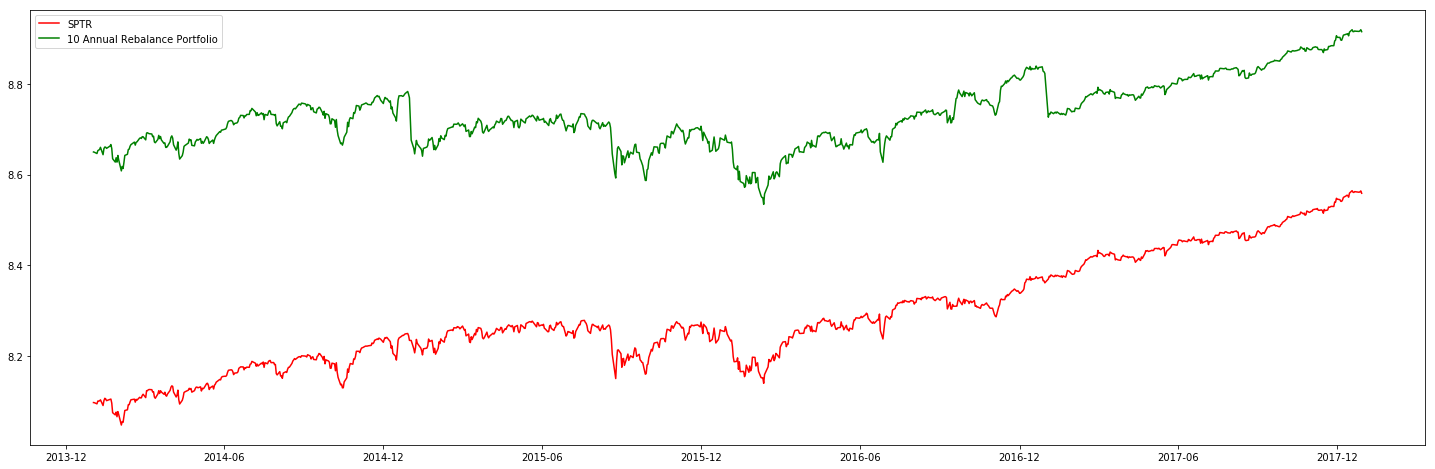

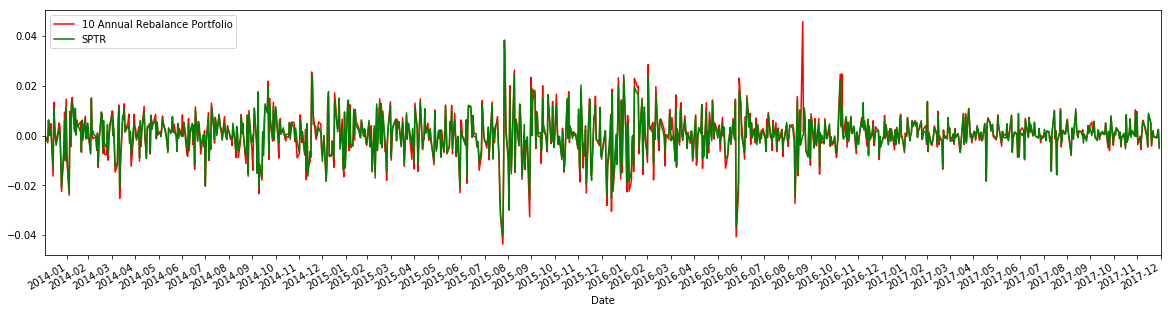

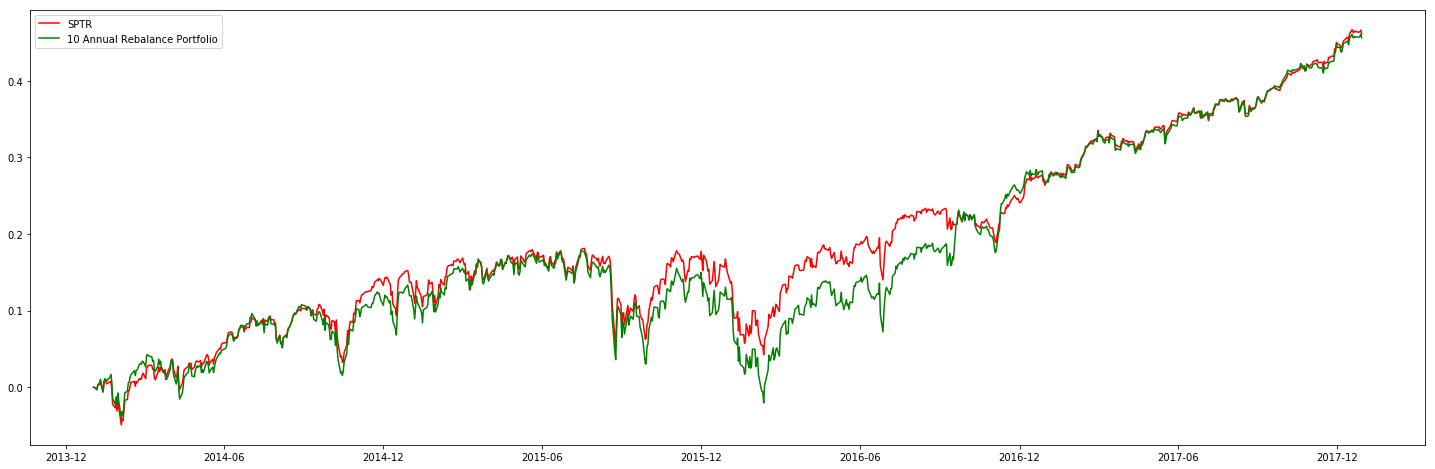

In [117]:
plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_annual_balance_10['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Annual Rebalance Portfolio' )
plt.legend(loc='upper left')
plt.show()
 

plt.figure(figsize=(25,8))
portfolio_test_annual_balance_10['Daily_Return'].plot(kind='line',figsize=(20,5),label = '10 Annual Rebalance Portfolio',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.show()

plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_annual_balance_10['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Annual Rebalance Portfolio' )
plt.legend(loc='upper left')
#plt.title('Comparison of Cumsum Returns between SPTR and 15 ETFs portfolio semi-annual rebalance')
plt.show()


In [546]:
All_ETFs_log = All_ETFs.apply(np.log)

All_ETFs_log .drop(['RYF','FTXO','PNQI', 'JHMC','PSCH','PSCI','PSCC',
                           'XNTK','PSCM','XTL','REM','RYF','XME'], axis=1, inplace=True) # 51Z ETFs left

In [47]:
All_ETFs_log_train.shape

(1511, 50)

## SPTR semi-annual rebalance

In [84]:
def  SPTR_semi_annual_balance(alpha_input= 6.1e-05):
        
    SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test_semi = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_semi = Lasso(alpha=alpha_input, fit_intercept=True,normalize=None, positive=True,random_state=123)

    LR_lasso_semi.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

    print('original coeff greater than 0 is ',np.sum(LR_lasso_semi.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_semi.coef_ < 0 ))
    print('original coeff equal to 0 is ',np.sum(LR_lasso_semi.coef_ == 0) )

    index_of_etfs = LR_lasso_semi.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_semi = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_semi.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test_semi.loc['20140101':'20140630','portf_forest'] = All_ETFs_log_semi.dot(nonzero_coeff).loc['20140101':'20140630'].copy()

    portfolio_test_semi.loc['20140101':'20140630','portfolio_test_intercept'] = portfolio_test_semi.loc['20140101':'20140630','portf_forest']+LR_lasso_semi.intercept_

    j = 0

    semi_dates_begin = pd.date_range(start='2014-07-01', end='2017-07-01', freq='6MS')

    semi_dates_end = pd.date_range(start='2014-06-30', end='2017-12-31', freq='6M',closed='right')

    for i in pd.date_range(start='2013-12-31', end='2017-06-30', freq='6M',closed='right'):
        
        All_ETFs_log_train = All_ETFs_log.loc['2008': i].copy()
        
        SPTR_log_train = SPTR_log.loc['2008': i].copy()
        
        print('\n\nfor range in 2008 to'+str(i))
        
        new_alpha = alpha_finding(X=All_ETFs_log_train, Y= SPTR_log_train)

        Lasso_Model = Lasso(alpha=new_alpha , fit_intercept=True,normalize=None,random_state=123)

        Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

        print('we select ETFs tickers are  ',All_ETFs_log_train.columns[Lasso_Model.coef_>0] )

        Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)

        check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
        
        index_of_etfs = Lasso_Model.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

        All_ETFs_log_semi = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

        coefficients= Lasso_Model.coef_.copy()

        nonzero_coeff  = coefficients[~(coefficients==0)].copy()

        nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

        portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest'] = All_ETFs_log_semi.dot(nonzero_coeff).loc[semi_dates_begin[j]:semi_dates_end[j]].copy()

        portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portfolio_test_intercept'] = portfolio_test_semi.loc[semi_dates_begin[j]:semi_dates_end[j],'portf_forest']+Lasso_Model.intercept_


        j+=1

        print('%sth loop is good'%(j))

    plt.figure(figsize=(25,8))
    plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test_semi['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='semi Portfolio' )
    plt.legend(loc='upper left')
    plt.title('Semi annaual Comparison between real SPTR and portfolio constructed on test data')
    plt.show()

    portfolio_test_semi['Daily_Return'] = portfolio_test_semi['portf_forest'].diff()
    portfolio_test_semi['Daily_Return'][0] = 0
    # to adjust after rebalancing, the price change. we don't want to count the daily return after rebalancing
    for i in ['2014-07-01','2015-01-02','2015-07-01','2016-01-04','2016-07-01','2017-01-03','2017-07-03']:
        portfolio_test_semi.loc[i,'Daily_Return'] = 0
        SPTR_log_test.loc[i,'Daily_Return'] = 0 

    portfolio_test_semi['Cumsum Daily_Return'] = portfolio_test_semi['Daily_Return'].cumsum()

    portfolio_test_semi['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'semi rebalance cumsum return',style='r-')
    SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
    plt.legend(loc='upper left')
    plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
    plt.title('Semi-annual Daily Return SPTR and Portfolio')
    plt.show()
    
    plt.figure(figsize=(25,8))
    plt.title('Cumsum daily return') 
    plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test_semi['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='Semi-annual balance Portfolio' )
    plt.legend(loc='upper left')
    plt.show()


    Track_error_semi = portfolio_test_semi['Daily_Return'] - SPTR_log_test['Daily_Return']


    print('Mean of Tracking Error is %.8f') %(np.mean(Track_error_semi))
    
    print('Std of Tracking Error is %.8f') %(np.std(Track_error_semi))
 
    #print('Sum of  Tracking Error is %.8f') %(np.sum(np.abs(Track_error_semi)))

    print('Semi-annual information ratio of the annual portfolio is %.3f')%(np.mean(Track_error_semi)/np.std(Track_error_semi))

    print('Semi-annual  Correlation coefficient between portfolio and SPTR is %.6f')%(
        np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test_semi['Daily_Return'].values.flatten())[0,1])
    return portfolio_test_semi

('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 40)


for range in 2008 to2014-06-30 00:00:00
('we select ETFs tickers are  ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'XLU',
       u'IDU', u'RWR'],
      dtype='object'))
p-value = 7.30094720911e-05 The series  is likely stationary.
1th loop is good


for range in 2008 to2014-12-31 00:00:00
('we select ETFs tickers are  ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'XLV', u'IBB', u'XLI', u'VIS', u'XLE',
       u'FXN', u'IDU', u'RWR'],
      dtype='object'))
p-value = 6.17663445897e-06 The series  is likely stationary.
2th loop is good


for range in 2008 to2015-06-30 00:00:00
('we select ETFs tickers are  ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'XLV', u'IBB', u'XLI', u'VIS', u'XLE',
       u'FXN', u'IDU', u'RWR'],
      dtype='object'))
p-value = 7.82288852984e-07 The series  is likely stationary.
3th loop is good


for range in 2008 to201

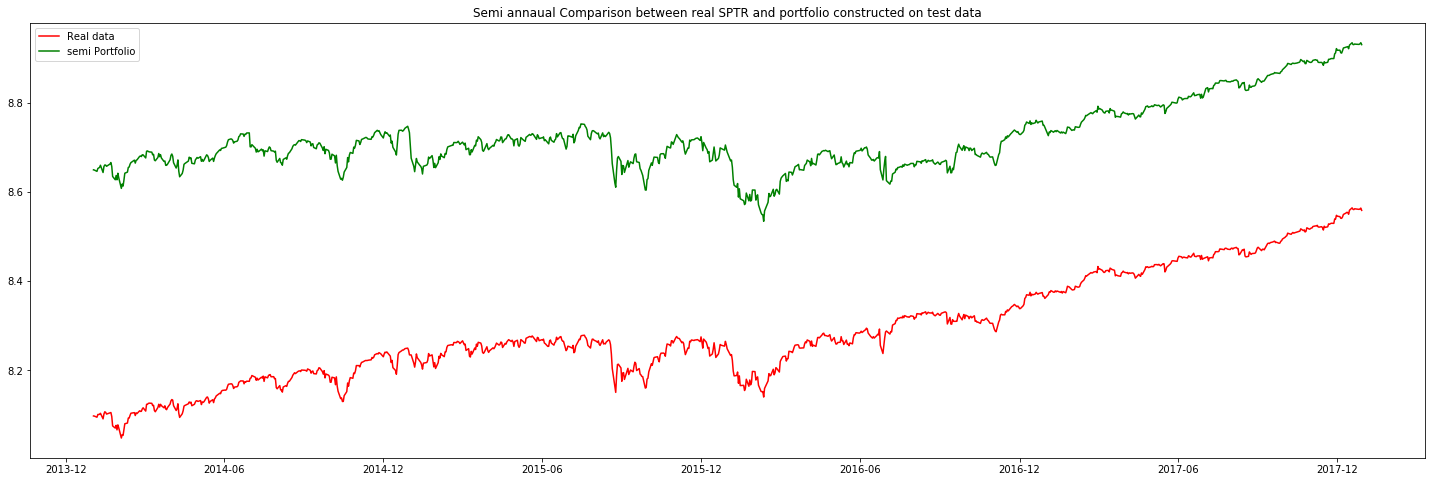

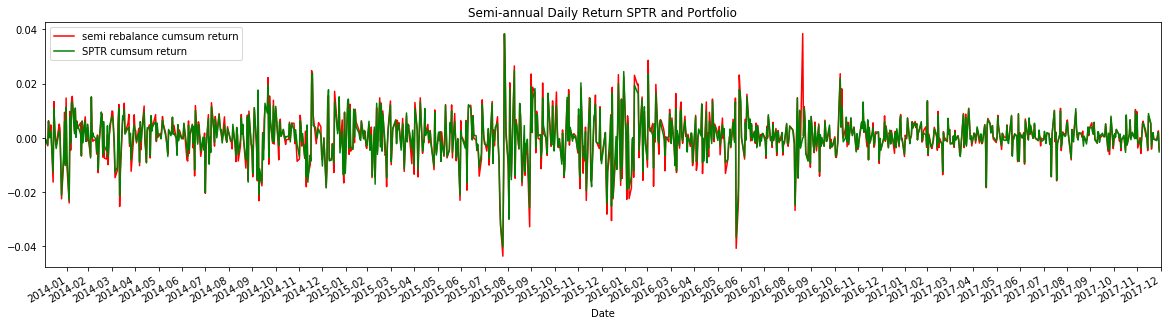

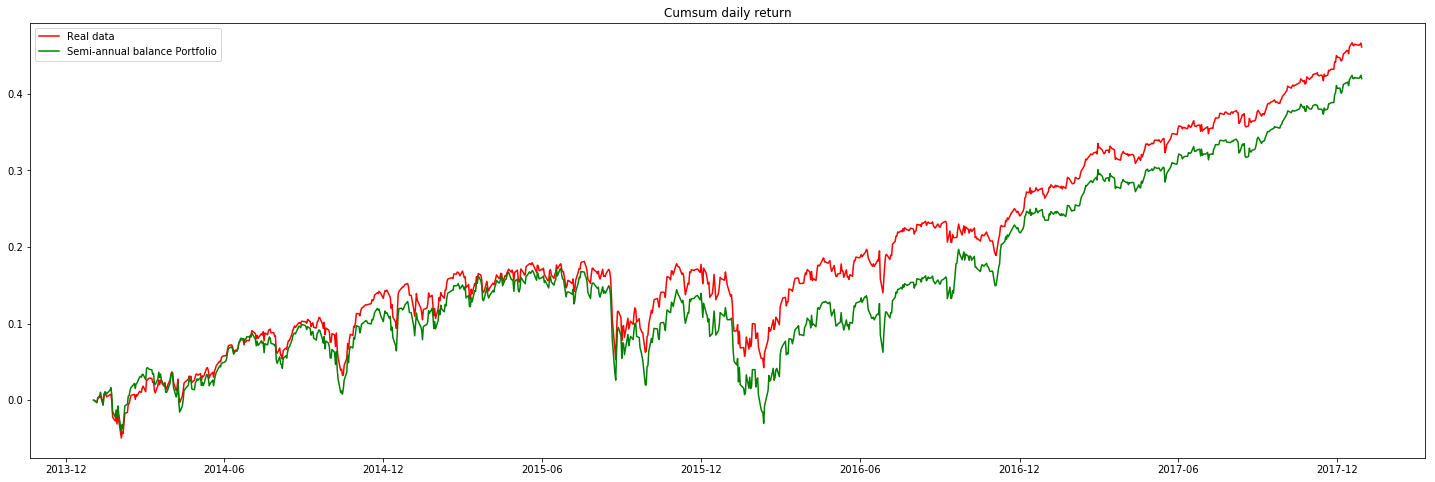

Mean of Tracking Error is -0.00002948
Std of Tracking Error is 0.00219601
Semi-annual information ratio of the annual portfolio is -0.013
Semi-annual  Correlation coefficient between portfolio and SPTR is 0.968419


In [85]:
portfolio_test_semi_annual_balance =  SPTR_semi_annual_balance(alpha_input=0.000605)

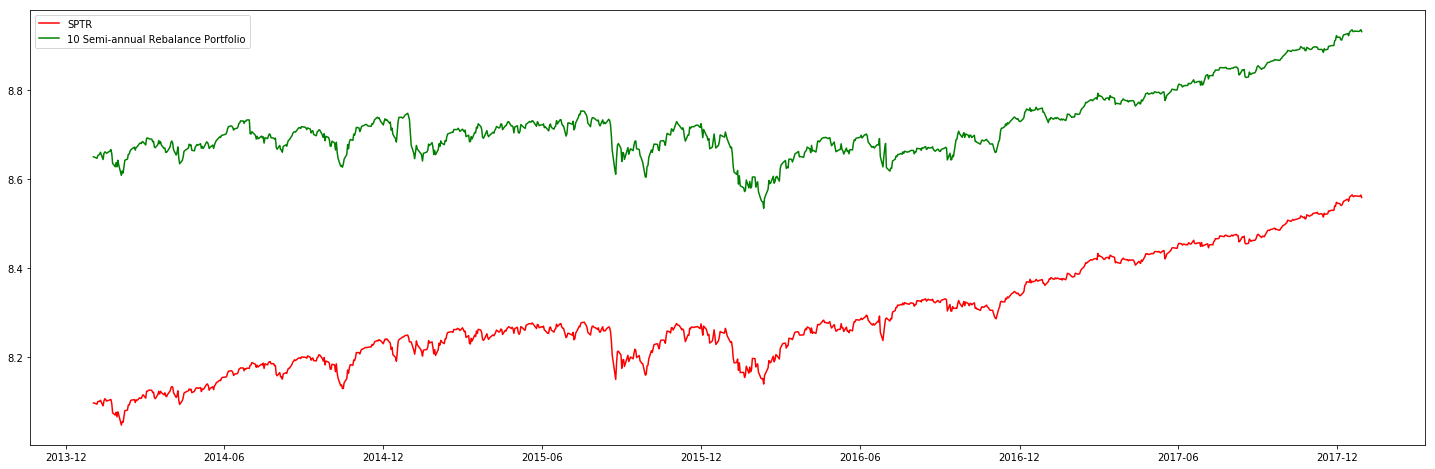

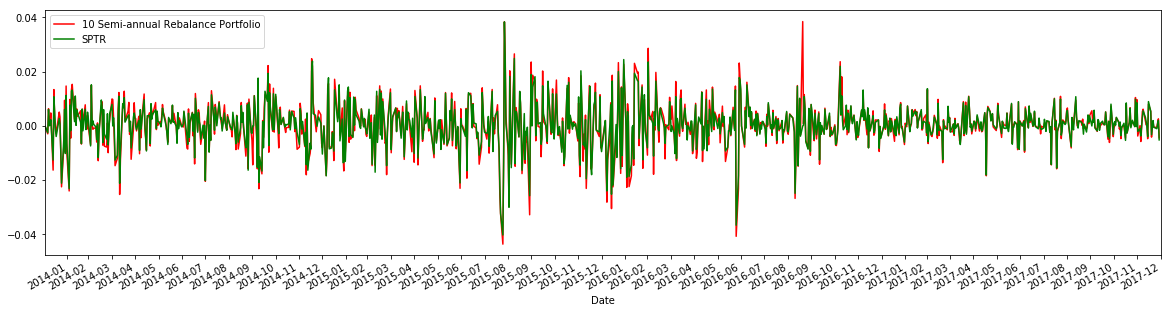

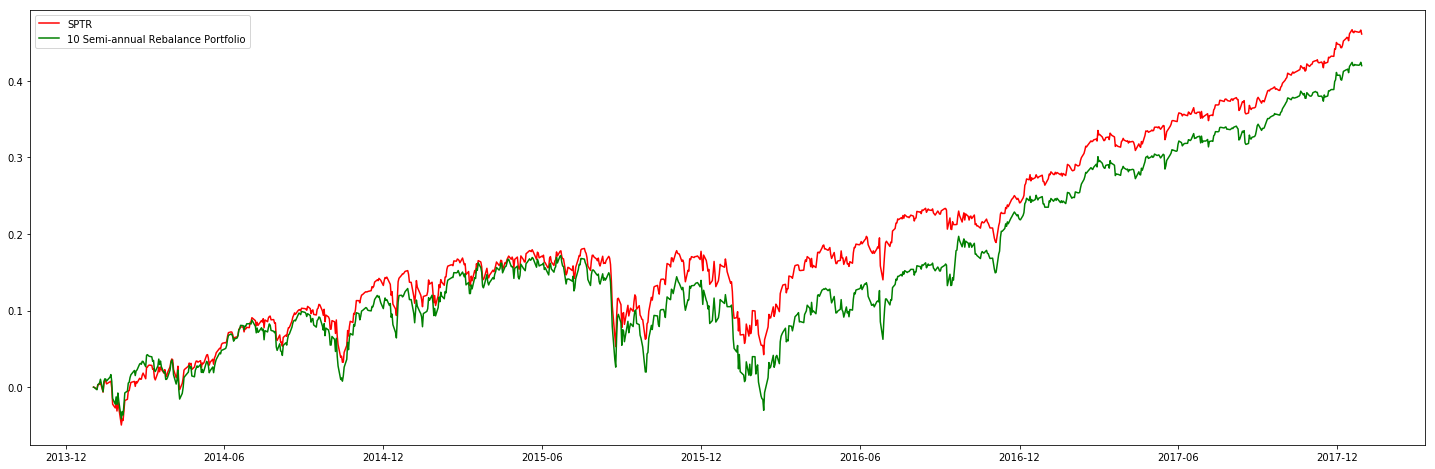

In [126]:
plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_semi_annual_balance['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Semi-annual Rebalance Portfolio' )
plt.legend(loc='upper left')
plt.show()
 

plt.figure(figsize=(25,8))
portfolio_test_semi_annual_balance['Daily_Return'].plot(kind='line',figsize=(20,5),label = '10 Semi-annual Rebalance Portfolio',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.show()

plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_semi_annual_balance['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Semi-annual Rebalance Portfolio' )
plt.legend(loc='upper left')
#plt.title('Comparison of Cumsum Returns between SPTR and 15 ETFs portfolio semi-annual rebalance')
plt.show()


## rebalance quarterly

In [120]:
def SPTR_quarter_balance(alpha_input= 6.1e-05):
    SPTR_log_train = SPTR_log.loc["2008-01": "2013-12-31"].copy()

    All_ETFs_log_train = All_ETFs_log.loc["2008-01": "2013-12-31"].copy()

    portfolio_test_quarter = pd.DataFrame(0,columns=['portf_forest','portfolio_test_intercept'] ,index=SPTR_log.loc['2014':'2017'].index)  # this is to store the test data from ETFs

    LR_lasso_quarter = Lasso(alpha= alpha_input ,fit_intercept=True,positive=True,normalize=None)

    LR_lasso_quarter.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

    print('original coeff greater than 0 is ',np.sum(LR_lasso_quarter.coef_ > 0 ))
    print('original coeff leass than 0 is ' ,np.sum(LR_lasso_quarter.coef_ < 0 ))
    print('original coeff equal to 0 is ',np.sum(LR_lasso_quarter.coef_ == 0) )

    index_of_etfs = LR_lasso_quarter.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

    All_ETFs_log_quarter = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio

    coefficients= LR_lasso_quarter.coef_.copy()

    nonzero_coeff  = coefficients[~(coefficients==0)].copy()

    nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

    portfolio_test_quarter.loc['2014Q1','portf_forest'] = All_ETFs_log_quarter.dot(nonzero_coeff).loc['2014Q1'].copy()

    portfolio_test_quarter.loc['2014Q1','portfolio_test_intercept'] = portfolio_test_quarter.loc['2014Q1','portf_forest']+LR_lasso_quarter.intercept_

    quarter_dates = [str(i)+j for i in range(2014,2018) for j in ['Q1','Q2','Q3','Q4']]

    j = 1


    for i in pd.date_range(start='2014Q1', end='2017Q4', freq='Q'):   
        
        All_ETFs_log_train = All_ETFs_log.loc['2008': i].copy()

        SPTR_log_train = SPTR_log.loc['2008': i].copy()

        print('\n\nfor range in 2008 to'+str(i))
        
        new_alpha = alpha_finding(X=All_ETFs_log_train, Y= SPTR_log_train)
        
        Lasso_Model = Lasso(alpha=new_alpha, fit_intercept=True,normalize=None, random_state=123)

        Lasso_Model.fit(All_ETFs_log_train,SPTR_log_train[['Adj Close']])

        print('we select ETF tickers are ',All_ETFs_log_train.columns[Lasso_Model.coef_>0] )

        Lasso_Model_residual = SPTR_log_train[['Adj Close']].values.flatten() - Lasso_Model.predict(All_ETFs_log_train)

        check_for_stationarity(Lasso_Model_residual.flatten(),cutoff=0.05)
        
        index_of_etfs = Lasso_Model.coef_ > 0 # these etfs are our portfolio etfs, we need those to build the portfolio,and to rebalance

        All_ETFs_log_quarter = All_ETFs_log.loc[: , index_of_etfs] .copy()  # this contains all the etfs we used to build portfolio
 
        coefficients= Lasso_Model.coef_.copy()

        nonzero_coeff  = coefficients[~(coefficients==0)].copy()

        nonzero_coeff = nonzero_coeff/nonzero_coeff.sum()

        portfolio_test_quarter.loc[quarter_dates[j],'portf_forest'] = All_ETFs_log_quarter.dot(nonzero_coeff).loc[quarter_dates[j]].copy()

        portfolio_test_quarter.loc[quarter_dates[j],'portfolio_test_intercept'] = portfolio_test_quarter.loc[quarter_dates[j],'portf_forest']+Lasso_Model.intercept_

        j+=1

        print('%sth loop is good'%(j))



    plt.figure(figsize=(25,8))
    plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test_quarter['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='quarter Portfolio' )
    plt.legend(loc='upper left')
    plt.title('Comparison between real S&P500 and portfolio constructed on test data')
    plt.show()

    portfolio_test_quarter['Daily_Return'] = portfolio_test_quarter['portf_forest'].diff()
    portfolio_test_quarter['Daily_Return'][0] = 0
    # to adjust after rebalancing, the price change. we don't want to count the daily return after rebalancing
    for i in ['2014-04-01','2014-07-01','2014-10-01','2015-01-02','2015-04-01','2015-07-01','2015-10-01','2016-01-04',
              '2016-04-01','2016-07-01','2016-10-03','2017-01-03','2017-04-03','2017-07-03','2017-10-02']:
        portfolio_test_quarter.loc[i,'Daily_Return'] = 0
        SPTR_log_test.loc[i,'Daily_Return'] = 0 
    portfolio_test_quarter['Cumsum Daily_Return'] = portfolio_test_quarter['Daily_Return'].cumsum()

    portfolio_test_quarter['Daily_Return'].plot(kind='line',figsize=(20,5),label = 'quarterly rebalance portfolio cumsum return',style='r-')
    SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR cumsum return',style='g-')
    plt.legend(loc='upper left')
    plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
    plt.title('Quarterly Cumsum Return SPTR and Portfolio')
    plt.show()

    plt.figure(figsize=(25,8))
    plt.title('Cumsum daily return') 
    plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='Real data' )
    plt.plot(SPTR_log_test.index,portfolio_test_quarter['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='Quarterly balance Portfolio' )
    plt.legend(loc='upper left')
    plt.show()

    Track_error_quarter = portfolio_test_quarter['Daily_Return'] - SPTR_log_test['Daily_Return']


    print('Mean of Tracking Error is %.8f') %(np.mean(Track_error_quarter))
    
    print('std of Tracking Error is %.8f') %(np.std(Track_error_quarter))

    #print('Sum of  Tracking Error is %.8f，') %(np.sum(np.abs(Track_error_quarter)))

    print('Quarter information ratio of the portfolio is %.3f')%(np.mean(Track_error_quarter)/np.std(Track_error_quarter))

    print('Quarterly  Correlation coefficient between portfolio and SPTR is %.6f')%(
        np.corrcoef(SPTR_log_test['Daily_Return'].values.flatten(),portfolio_test_quarter['Daily_Return'].values.flatten())[0,1])

    return portfolio_test_quarter
    

('original coeff greater than 0 is ', 10)
('original coeff leass than 0 is ', 0)
('original coeff equal to 0 is ', 40)


for range in 2008 to2014-03-31 00:00:00
('we select ETF tickers are ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'XLU',
       u'IDU', u'RWR'],
      dtype='object'))
p-value = 3.58735104122e-05 The series  is likely stationary.
2th loop is good


for range in 2008 to2014-06-30 00:00:00
('we select ETF tickers are ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'IBB', u'VIS', u'XLE', u'RYE', u'XLU',
       u'IDU', u'RWR'],
      dtype='object'))
p-value = 7.30094720911e-05 The series  is likely stationary.
3th loop is good


for range in 2008 to2014-09-30 00:00:00
('we select ETF tickers are ', Index([u'XLK', u'XLF', u'XLY', u'VCR', u'XLV', u'IBB', u'XLI', u'VIS', u'XLE',
       u'RYE', u'FXN', u'XLU', u'IDU', u'RWR'],
      dtype='object'))
p-value = 8.05849699161e-05 The series  is likely stationary.
4th loop is good


for range in 2008 to2

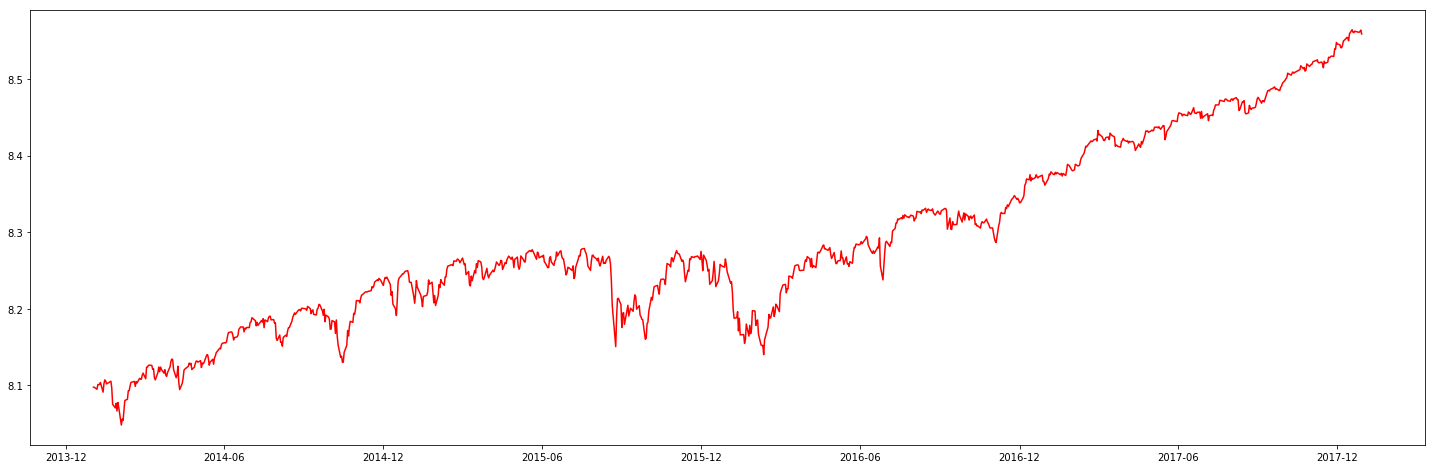

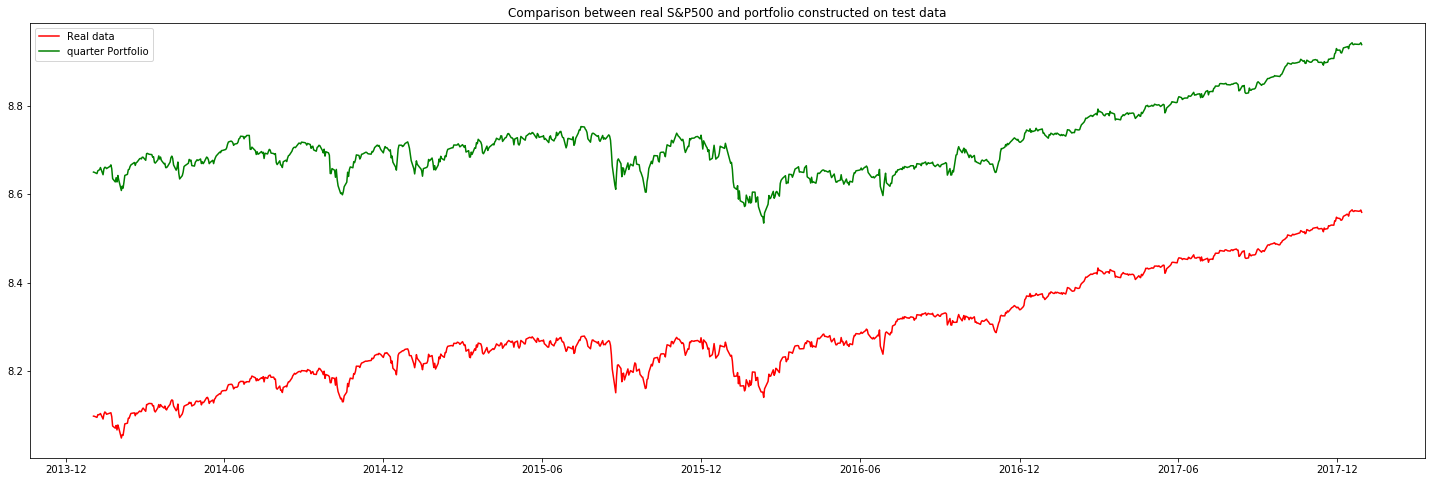

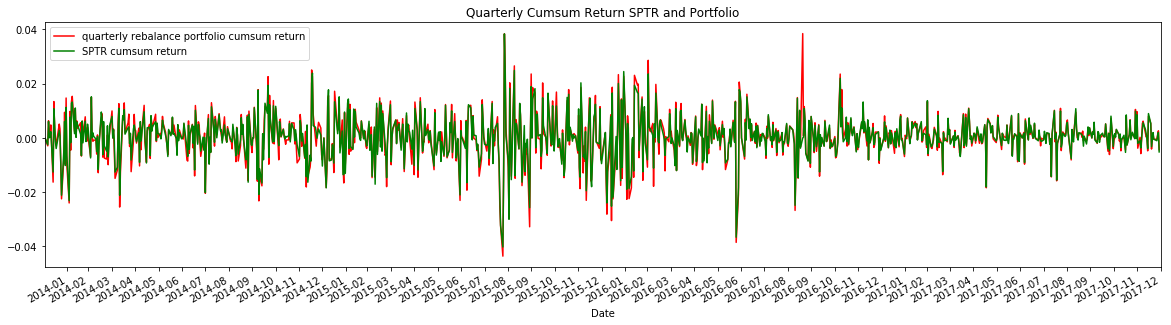

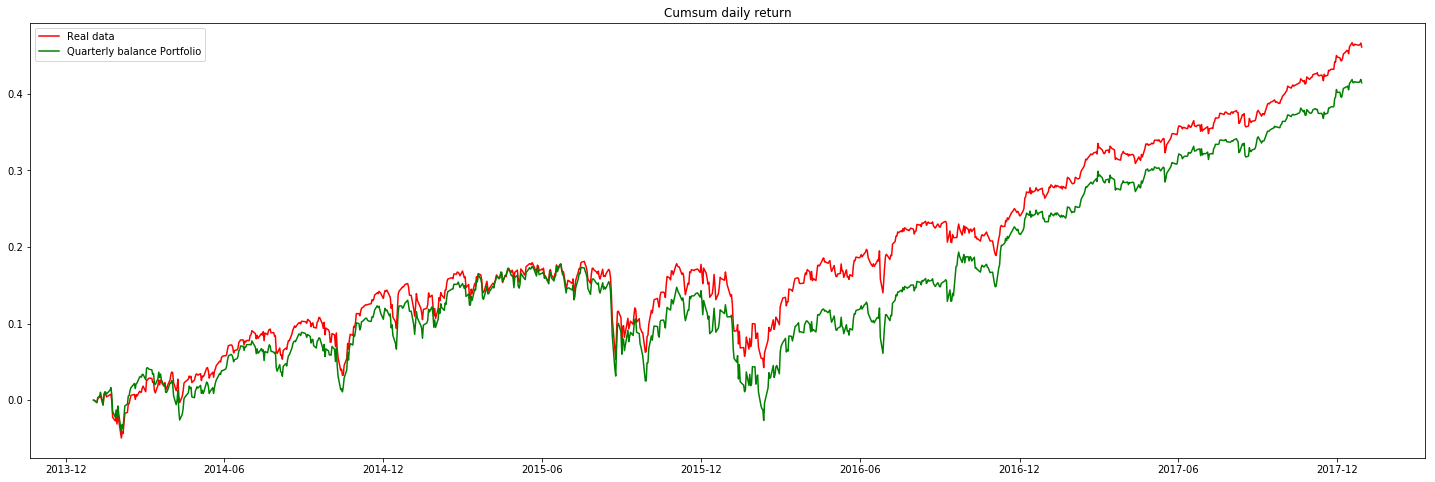

Mean of Tracking Error is -0.00003730
std of Tracking Error is 0.00215124
Quarter information ratio of the portfolio is -0.017
Quarterly  Correlation coefficient between portfolio and SPTR is 0.969016


In [121]:
portfolio_test_quarter_balance_5 =  SPTR_quarter_balance(alpha_input=0.000605)

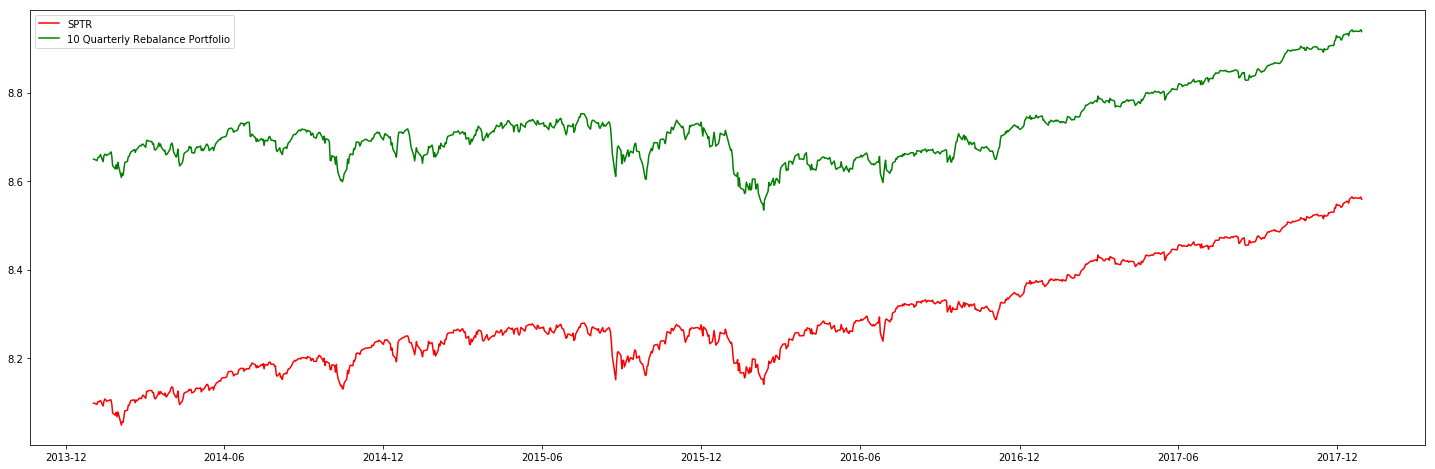

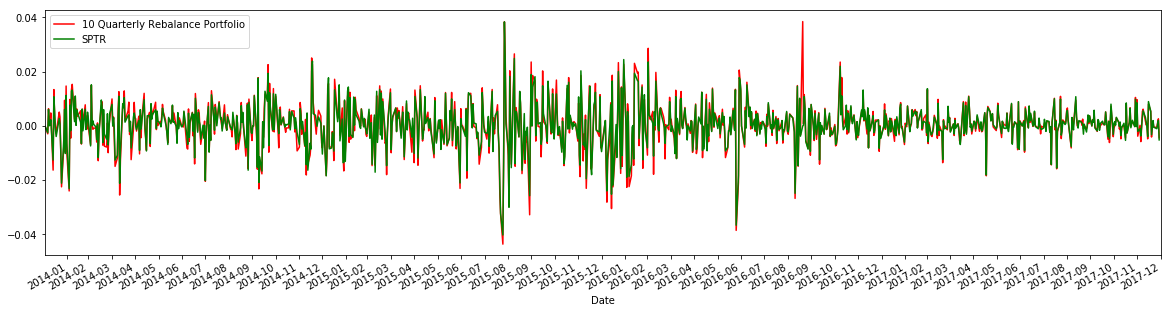

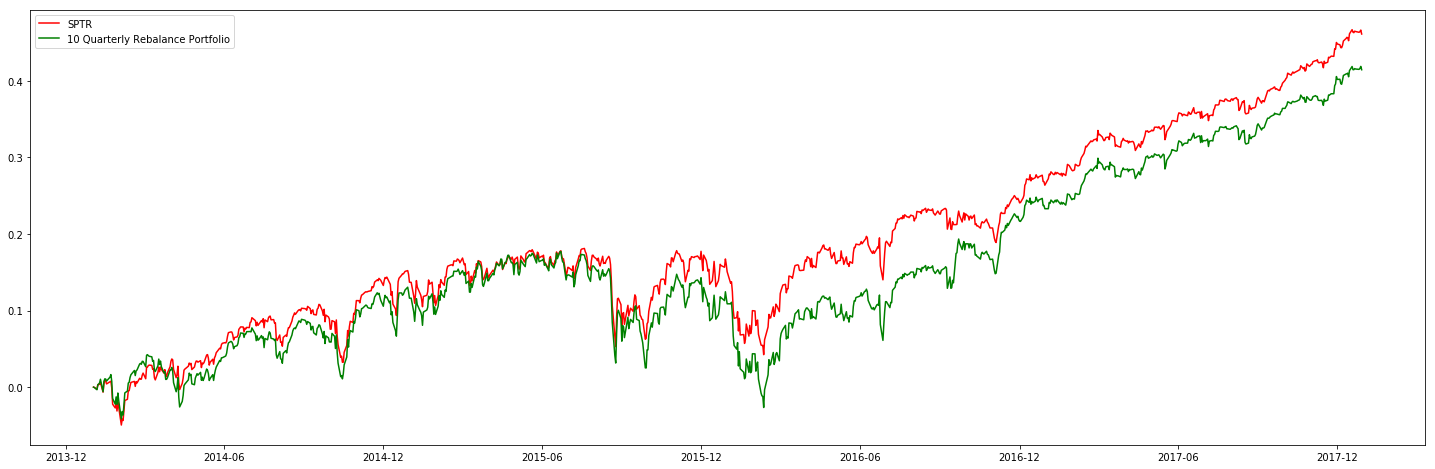

In [125]:
plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Adj Close'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_quarter_balance_5['portfolio_test_intercept'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Quarterly Rebalance Portfolio' )
plt.legend(loc='upper left')
plt.show()
 

plt.figure(figsize=(25,8))
portfolio_test_quarter_balance_5['Daily_Return'].plot(kind='line',figsize=(20,5),label = '10 Quarterly Rebalance Portfolio',style='r-')
SPTR_log_test['Daily_Return'].loc["2014-01-01": "2017-12-31"].plot(kind='line',figsize=(20,5),label = 'SPTR',style='g-')
plt.legend(loc='upper left')
plt.xticks( pd.date_range(start='2014-1-01', end='2018-01-01', freq = 'M'))
plt.show()

plt.figure(figsize=(25,8))
plt.plot(SPTR_log_test.index,SPTR_log_test['Cumsum Daily_Return'], 'r-', label='SPTR' )
plt.plot(SPTR_log_test.index,portfolio_test_quarter_balance_5['Cumsum Daily_Return'].loc["2014-01-01": "2017-12-31"], 'g-', label='10 Quarterly Rebalance Portfolio' )
plt.legend(loc='upper left')
#plt.title('Comparison of Cumsum Returns between SPTR and 15 ETFs portfolio semi-annual rebalance')
plt.show()

In [21]:
def check_for_stationarity(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        #return True
    else:
        print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        #return False

In [22]:
def check_for_stationarity_no_print(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = ADF(X)[1]
    if pvalue < cutoff:
        #print 'p-value = ' + str(pvalue) + ' The series '  +' is likely stationary.'
        return True
    else:
        #print 'p-value = ' + str(pvalue) + ' The series '+' is likely non-stationary.'
        return False